In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import pandas as pd

import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [2]:
baseline_file = 'ddf_accourd_sf0.05_lsf0.2_lsr0.3_v2.1_10yrs.db' #get_baseline()
runName = os.path.split(baseline_file)[-1].replace('.db', '')

print(runName)

ddf_accourd_sf0.05_lsf0.2_lsr0.3_v2.1_10yrs


In [3]:
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [6]:
class CumulativeMetric(maf.metrics.BaseMetric):
    """For plotting up the cumulative number of observations.
    Expected to be used with a UniSlicer or UserPointSlicer with one point.
    
    Parameters
    ----------
    bins : `np.array` (None)
        The points to interpolate the cumulative number of observations to. If None,
        then the range of the data is used.
    """
    def __init__(self, metricName="Cumulative", time_col='observationStartMJD', 
                 night_col='night', bins=None, **kwargs):
        super().__init__(col=[time_col, night_col], metricName=metricName, metricDtype="object",**kwargs)
        self.time_col = time_col
        self.night_col = night_col
        self.bins = bins
        self.plotDict = {'xlabel': 'MJD (days)', 'ylabel': 'N obs'}
    def run(self, dataSlice, slicePoint=None):
        dataSlice.sort(order=self.time_col)
        if self.bins is None:
            bins = np.arange(dataSlice[self.night_col].min(), dataSlice[self.night_col].max()+1, 1)
        cumulative_number = np.arange(dataSlice.size)+1
        yresult = np.interp(bins, dataSlice[self.night_col], cumulative_number)
        xresult = bins
        return {'x': xresult, 'y': yresult, 'plotDict': self.plotDict}
        

In [13]:
class XyPlotter(maf.plots.BasePlotter):
    """Bare-bones plotter for making scatter plots.
    """
    def __init__(self):
        self.objectPlotter = True
        self.plotType = 'simple'
        self.defaultPlotDict = {"title": None,
                               "xlabel": '',
                               "ylabel": ''}
        
    def __call__(self, metricValueIn, slicer, userPlotDict, fignum=None):
        
        plotDict = {}
        plotDict.update(self.defaultPlotDict)
        plotDict.update(userPlotDict)
        plotDict.update(metricValueIn[0]['plotDict'])
        
        fig = plt.figure(fignum)
        ax = fig.add_subplot(111)
        x = metricValueIn[0]['x']
        y = metricValueIn[0]['y']
        ax.plot(x, y)
        ax.set_title(plotDict['title'])
        ax.set_xlabel(plotDict['xlabel'])
        ax.set_ylabel(plotDict['ylabel'])
        return fig.number
    

In [14]:
plots = [XyPlotter()]
plotDict = {}
bundleList = []
slicer = maf.UniSlicer()
metric = CumulativeMetric() 
bundleList.append(maf.MetricBundle(metric, slicer, 'note like "DD:ELAISS1"', plotFuncs=plots, 
                                   plotDict=plotDict, runName=runName))
# Ugh, need to wipe out the auto generated summary stat.
bundleList[0].summaryMetrics = []

In [15]:
bundleDict = maf.metricBundles.makeBundlesDictFromList(bundleList)

In [16]:
bgroup = maf.metricBundles.MetricBundleGroup(bundleDict, baseline_file, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying table None with constraint note like "DD:ELAISS1" for columns ['observationStartMJD', 'night']
Found 21667 visits
Running:  ['ddf_accourd_sf0_05_lsf0_2_lsr0_3_v2_1_10yrs_Cumulative_note_like_DD_ELAISS1_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "note like "DD:ELAISS1"" constraint now.
Plotting complete.


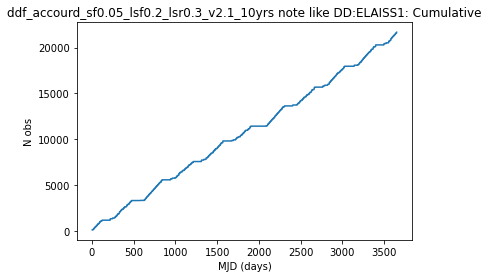

In [17]:
bgroup.plotAll(closefigs=False)